In [1]:
from __future__ import print_function, division

import os
import pandas as pd
from skimage import io, transform
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [2]:
nclasses = 14951
learning_rate = 0.0002
batch_size = 100
num_epochs = 10

In [3]:
#for test
learning_rate = 0.0002
batch_size = 5
num_epochs = 18

In [4]:
class LandmarksDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform = None):
        self.csv_data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.csv_data)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, 
                                'train', 
                                str(self.csv_data.iloc[idx, 2]), 
                                str(self.csv_data.iloc[idx, 0] + '.jpg'))
        image  = io.imread(img_name)
        label  = torch.from_numpy(self.csv_data.iloc[idx, 2:].as_matrix().astype('long').reshape(-1, 1))
        sample = {'image': image, 'label': label}
        
        if self.transform:
            sample['image'] = self.transform(sample['image'])
            
        return sample

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ])
}

landmarks_dataset = {
    'train' : LandmarksDataset(csv_file  = './eda/qualified_train.csv',
                               root_dir  = '/mnt/sw/workspace/Google',
                               transform = data_transforms['train']),
    'val'   : LandmarksDataset(csv_file  = './eda/qualified_validation.csv',
                               root_dir  = '/mnt/sw/workspace/Google',
                               transform = data_transforms['val'])
}

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation

dataloaders = {
    x: torch.utils.data.DataLoader(landmarks_dataset[x], batch_size = batch_size, shuffle = True, num_workers = 4)
    for x in ['train', 'val']
}

dataset_sizes = { x: len(landmarks_dataset[x]) for x in ['train', 'val'] }

print(dataset_sizes['train'])
print(dataset_sizes['val'])

186261
46566


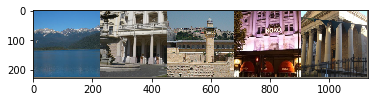

In [7]:
def imshow(inp):
    """Imshow for Tensor."""
    inp  = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp  = std * inp + mean
    inp  = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs['image'])

imshow(out)

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
        
            for sampled_batch in dataloaders[phase]:
                inputs = sampled_batch['image']
                labels = sampled_batch['label']
                inputs = Variable(inputs).cuda()
                labels = Variable(labels[:, 0, 0]).cuda()
                optimizer.zero_grad()
            
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds.data == labels.data)
                    
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
            
        print
            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:
model_ft = models.resnet18(pretrained = True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, nclasses)

model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr = learning_rate)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 7, gamma = 0.1)

In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs = num_epochs)

Epoch 1/18
----------
train Loss: 1.9255 Acc: 0.0001
val Loss: 1.9351 Acc: 0.0002
Epoch 2/18
----------
train Loss: 1.9014 Acc: 0.0001
val Loss: 2.5153 Acc: 0.0002
Epoch 3/18
----------
train Loss: 1.8869 Acc: 0.0005
val Loss: 3.6253 Acc: 0.0010
Epoch 4/18
----------
train Loss: 1.7879 Acc: 0.0035
val Loss: 2.8247 Acc: 0.0071
Epoch 5/18
----------
train Loss: 1.6031 Acc: 0.0209
val Loss: 19.5042 Acc: 0.0330
Epoch 6/18
----------
train Loss: 1.3913 Acc: 0.0673
val Loss: 57.9677 Acc: 0.1010
Epoch 7/18
----------
train Loss: 1.2126 Acc: 0.1310
val Loss: 37.4303 Acc: 0.1826
Epoch 8/18
----------
train Loss: 1.0399 Acc: 0.2069
val Loss: 180.2325 Acc: 0.2057
Epoch 9/18
----------
train Loss: 0.9965 Acc: 0.2305
val Loss: 148.0908 Acc: 0.2332
Epoch 10/18
----------
train Loss: 0.9691 Acc: 0.2428
val Loss: 96.9633 Acc: 0.2532
Epoch 11/18
----------
train Loss: 0.9446 Acc: 0.2583
val Loss: 184.1687 Acc: 0.2543
Epoch 12/18
----------
train Loss: 0.9272 Acc: 0.2671
val Loss: 226.1913 Acc: 0.2623
E

In [11]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, sampled_batch in enumerate(dataloaders['val']):
        inputs = sampled_batch['image']
        labels = sampled_batch['label']
        inputs = Variable(inputs).cuda()
        labels = Variable(labels[:, 0, 0]).cuda()
    
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('Predicted: {}'.format(preds[j]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

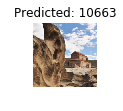

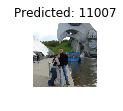

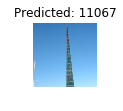

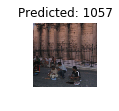

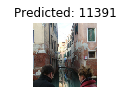

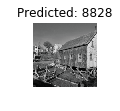

In [12]:
visualize_model(model_ft)